In [2]:
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt

In [3]:
# Load data from CSV
data = pd.read_csv('Merged_ServiceTime.csv')

# Convert 'StartTime' and 'PayTime' to datetime
data['StartTime'] = pd.to_datetime(data['StartTime'], format='%H:%M:%S')
data['PayTime'] = pd.to_datetime(data['PayTime'], format='%H:%M:%S')

# Calculate service times in minutes
data['ServiceTimeMinutes'] = data['ServTime']

# Calculate inter-arrival times in minutes
data['InterArrivalTime'] = data['StartTime'].diff().dt.total_seconds() / 60
data['InterArrivalTime'].iloc[0] = 0  # Assuming the first arrival is at time 0

# Drop the first row if it's not meaningful in simulation context (optional)
data = data.iloc[1:].reset_index(drop=True)

/var/folders/tf/6tszc4p95dn6fjrhhsz6w6380000gn/T/ipykernel_2873/642485745.py:13: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  data['InterArrivalTime'].iloc[0] = 0  # Assuming the first arrival is at time 0
/var/folders/tf/6tszc4p95dn6fjrhhs

# M/M/1 Stochastic Model

In [4]:
def simulate_mm1_queue(inter_arrival_times, service_times):
    # Initialize variables
    num_customers = len(inter_arrival_times)
    arrival_times = np.cumsum(inter_arrival_times)
    start_service_times = np.zeros(num_customers)
    end_service_times = np.zeros(num_customers)
    wait_times = np.zeros(num_customers)

    # Simulate the queue
    for i in range(num_customers):
        if i == 0:
            start_service_times[i] = arrival_times[i]
        else:
            start_service_times[i] = max(arrival_times[i], end_service_times[i-1])
        
        end_service_times[i] = start_service_times[i] + service_times[i]
        wait_times[i] = start_service_times[i] - arrival_times[i]

    return arrival_times, start_service_times, end_service_times, wait_times

# Use the function with data from CSV
arrival_times, start_service_times, end_service_times, wait_times = simulate_mm1_queue(data['InterArrivalTime'].values, data['ServiceTimeMinutes'].values)

Average waiting time: 167650.63271550887 minutes


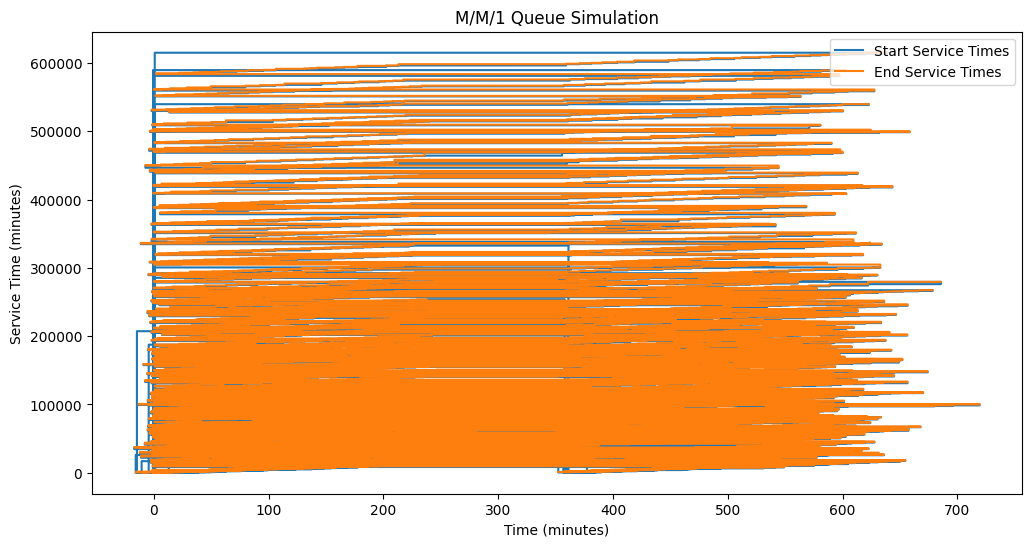

In [5]:
# Print average waiting time
print(f"Average waiting time: {np.mean(wait_times)} minutes")

# Plot the results
plt.figure(figsize=(12, 6))
plt.step(arrival_times, start_service_times, where='post', label='Start Service Times')
plt.step(arrival_times, end_service_times, where='post', label='End Service Times')
plt.legend()
plt.xlabel('Time (minutes)')
plt.ylabel('Service Time (minutes)')
plt.title('M/M/1 Queue Simulation')
plt.show()

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime

In [7]:
# Load the data from a CSV file
df = pd.read_csv('Merged_ServiceTime.csv')

# Prepare the Data

In [8]:
# Convert 'StartTime' to datetime object and 'ServTime' to minutes
df['StartTime'] = pd.to_datetime(df['StartTime'], format='%H:%M:%S')
df['ServTime'] /= 60  # Convert service time from seconds to minutes for simplicity

# Calculate interarrival times in minutes
df['Interarrival'] = df['StartTime'].diff().dt.total_seconds() / 60
df['Interarrival'].iloc[0] = 0  # Set the first interarrival time to 0

/var/folders/tf/6tszc4p95dn6fjrhhsz6w6380000gn/T/ipykernel_2873/4053323027.py:7: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  df['Interarrival'].iloc[0] = 0  # Set the first interarrival time to 0
/var/folders/tf/6tszc4p95dn6fjrhhsz6w638000

# Simulate the M/M/1 Queue

In [9]:
# Initialize variables
queue = []  # This will store the time when each customer will be done with the service
time_elapsed = 0
waiting_times = []

# Queue simulation
for index, row in df.iterrows():
    arrival_time = time_elapsed + row['Interarrival']
    if queue:
        # Remove all served customers from the queue
        queue = [q for q in queue if q > arrival_time]
    
    if queue:
        start_service_time = max(queue[-1], arrival_time)
    else:
        start_service_time = arrival_time
    
    finish_service_time = start_service_time + row['ServTime']
    queue.append(finish_service_time)
    waiting_time = start_service_time - arrival_time
    waiting_times.append(waiting_time)
    time_elapsed = arrival_time

# Visualize the Waiting Time

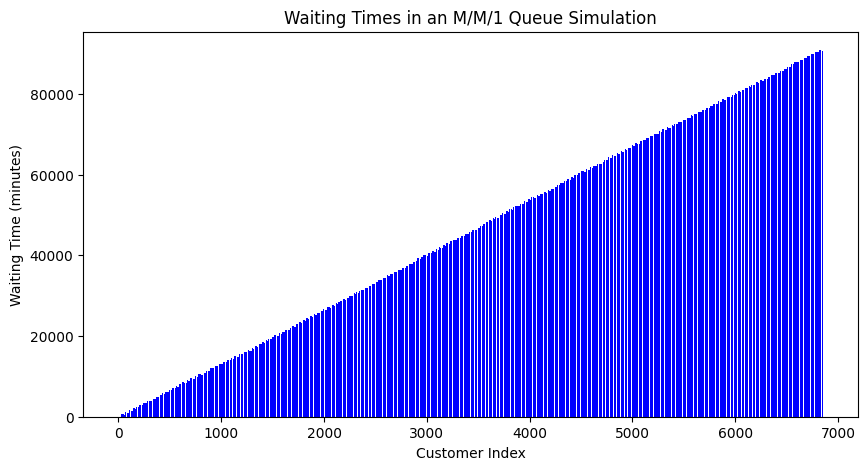

In [10]:
plt.figure(figsize=(10, 5))
plt.bar(range(len(waiting_times)), waiting_times, color='blue')
plt.xlabel('Customer Index')
plt.ylabel('Waiting Time (minutes)')
plt.title('Waiting Times in an M/M/1 Queue Simulation')
plt.show()

# Improvement

In [13]:
import pandas as pd
from collections import deque
import datetime

# Load the CSV data into a DataFrame
df = pd.read_csv('Merged_ServiceTime.csv')

# Helper function to convert 'HH:MM:SS' to seconds since midnight
def time_to_seconds(t):
    h, m, s = map(int, t.split(':'))
    return h * 3600 + m * 60 + s

# Convert StartTime to seconds since midnight for easier calculation
df['StartTimeSec'] = df['StartTime'].apply(time_to_seconds)

# Sort data by StartTimeSec to ensure correct order of service
df = df.sort_values(by='StartTimeSec')

# Calculate interarrival times, assume the first customer has an interarrival time of 0
df['Interarrival'] = df['StartTimeSec'].diff().fillna(0)

# Initialize queue and variables for simulation
queue = deque()
waiting_times = []

# Queue simulation
for index, row in df.iterrows():
    arrival_time = row['StartTimeSec']
    # Remove all served customers from the queue
    while queue and queue[0] <= arrival_time:
        queue.popleft()

    if queue:
        start_service_time = max(queue[-1], arrival_time)
    else:
        start_service_time = arrival_time

    finish_service_time = start_service_time + row['ServTime']
    queue.append(finish_service_time)
    waiting_time = start_service_time - arrival_time
    waiting_times.append(waiting_time)

# Add the waiting times to the DataFrame
df['WaitingTime'] = waiting_times

# Display or save the updated DataFrame
print(df[['ID', 'StartTime', 'ServTime', 'WaitingTime']])



              ID StartTime  ServTime  WaitingTime
2242  H087A71FE2  08:14:33     502.0          0.0
2189  H252BB3EED  08:15:53     619.0        422.0
3982  H29D007AAE  08:16:56    1509.0        978.0
894   HE4BB48DC6  08:18:21     785.0       2402.0
5257  HF311A89D1  08:19:03    1253.0       3145.0
...          ...       ...       ...          ...
743   H612FFA4BC  19:50:08       NaN          NaN
6536  H7891936B7  19:51:44     945.0          NaN
4432  H8A84228CA  19:57:16       NaN          NaN
6537  HF049EB293  20:07:29    1412.0          NaN
6538  HCEA6DC53B  20:31:01     533.0          NaN

[6853 rows x 4 columns]


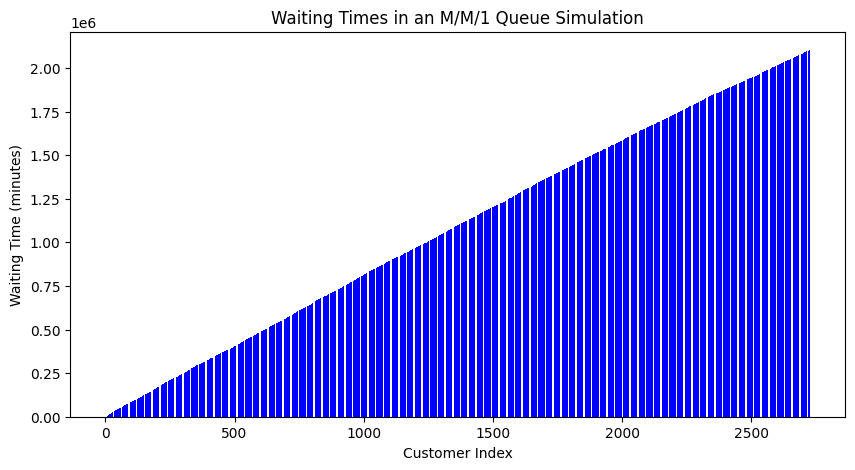

In [16]:
plt.figure(figsize=(10, 5))
plt.bar(range(len(waiting_times)), waiting_times, color='blue')
plt.xlabel('Customer Index')
plt.ylabel('Waiting Time (minutes)')
plt.title('Waiting Times in an M/M/1 Queue Simulation')
plt.show()

# 5 Scheduling Algorithms

In [17]:
import numpy as np
import pandas as pd
from collections import deque

# Create synthetic data for simulation
np.random.seed(42)
num_jobs = 100
arrivals = np.cumsum(np.random.exponential(scale=10, size=num_jobs))  # Exponential inter-arrival times
processing_times = np.random.exponential(scale=5, size=num_jobs)  # Exponential service times
due_dates = arrivals + np.random.uniform(20, 100, size=num_jobs)  # Random due dates

df = pd.DataFrame({
    'arrival': arrivals,
    'processing_time': processing_times,
    'due_date': due_dates
})


In [18]:
# Different scheduling strategies
def schedule_fcfs(df):
    return df.sort_values('arrival')

def schedule_spt(df):
    return df.sort_values('processing_time')

def schedule_edd(df):
    return df.sort_values('due_date')

def schedule_slack_time_remaining(df, current_time):
    df['slack_time'] = df['due_date'] - (current_time + df['processing_time'])
    return df.sort_values('slack_time')

def schedule_critical_ratio(df, current_time):
    df['critical_ratio'] = (df['due_date'] - current_time) / df['processing_time']
    return df.sort_values('critical_ratio')

# Function to simulate the queue
def simulate_queue(df, scheduler, context=''):
    queue = deque()
    current_time = 0
    total_waiting_time = 0
    total_system_time = 0

    while not df.empty:
        # Apply the scheduling strategy
        if context == 'time_dependent':
            df = scheduler(df, current_time)
        else:
            df = scheduler(df)

        for index, row in df.iterrows():
            arrival_time = row['arrival']
            processing_time = row['processing_time']
            start_time = max(current_time, arrival_time)
            finish_time = start_time + processing_time
            waiting_time = start_time - arrival_time
            system_time = finish_time - arrival_time

            total_waiting_time += waiting_time
            total_system_time += system_time

            # Update current time
            current_time = finish_time

            # Remove the job from the dataframe
            df = df.drop(index)
            break

    average_waiting_time = total_waiting_time / num_jobs
    average_system_time = total_system_time / num_jobs
    return average_waiting_time, average_system_time



In [19]:
# Run the simulation for each scheduling algorithm
results = {}
results['FCFS'] = simulate_queue(df.copy(), schedule_fcfs)
results['SPT'] = simulate_queue(df.copy(), schedule_spt)
results['EDD'] = simulate_queue(df.copy(), schedule_edd)
results['Slack Time Remaining'] = simulate_queue(df.copy(), schedule_slack_time_remaining, 'time_dependent')
results['Critical Ratio'] = simulate_queue(df.copy(), schedule_critical_ratio, 'time_dependent')

# Print results
for k, v in results.items():
    print(f"{k}: Average Waiting Time = {v[0]:.2f}, Average System Time = {v[1]:.2f}")

FCFS: Average Waiting Time = 7.53, Average System Time = 12.41
SPT: Average Waiting Time = 487.53, Average System Time = 492.41
EDD: Average Waiting Time = 25.12, Average System Time = 30.00
Slack Time Remaining: Average Waiting Time = 26.78, Average System Time = 31.67
Critical Ratio: Average Waiting Time = 67.36, Average System Time = 72.24


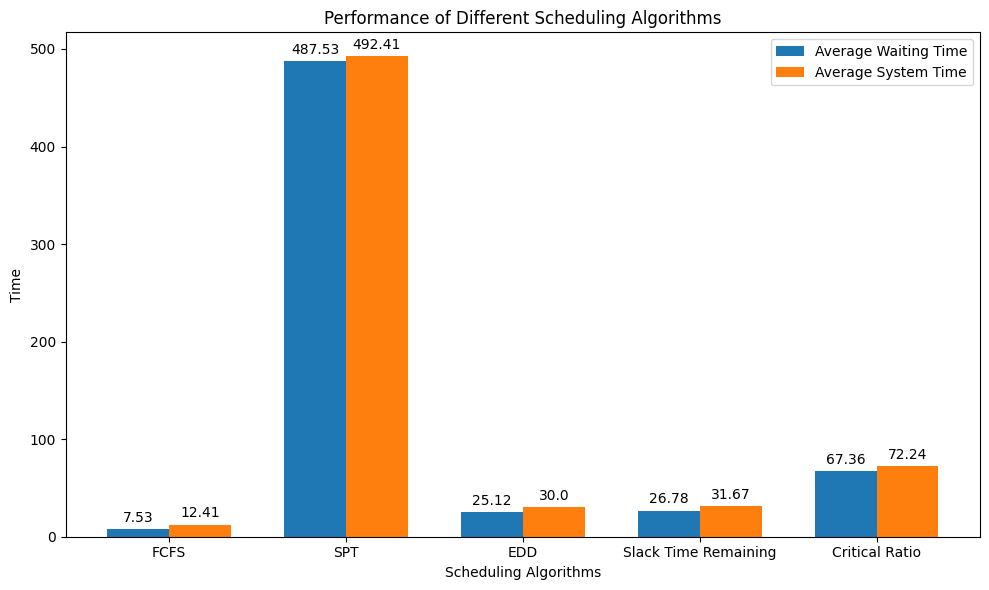

In [20]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Assuming the rest of the code provided earlier is included here
# Same synthetic data generation and function definitions…

# Simulation code as before…

# Visualization of the results
def plot_results(results):
    labels = list(results.keys())
    waiting_times = [results[alg][0] for alg in labels]
    system_times = [results[alg][1] for alg in labels]

    x = np.arange(len(labels))  # the label locations
    width = 0.35  # the width of the bars

    fig, ax = plt.subplots(figsize=(10, 6))
    rects1 = ax.bar(x - width/2, waiting_times, width, label='Average Waiting Time')
    rects2 = ax.bar(x + width/2, system_times, width, label='Average System Time')

    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_xlabel('Scheduling Algorithms')
    ax.set_ylabel('Time')
    ax.set_title('Performance of Different Scheduling Algorithms')
    ax.set_xticks(x)
    ax.set_xticklabels(labels)
    ax.legend()

    def autolabel(rects):
        """Attach a text label above each bar in *rects*, displaying its height."""
        for rect in rects:
            height = rect.get_height()
            ax.annotate('{}'.format(round(height, 2)),
                        xy=(rect.get_x() + rect.get_width() / 2, height),
                        xytext=(0, 3),  # 3 points vertical offset
                        textcoords="offset points",
                        ha='center', va='bottom')

    autolabel(rects1)
    autolabel(rects2)

    fig.tight_layout()

    plt.show()

# Assuming the results dictionary is populated as before
plot_results(results)

# Sensitivity Analysis

/var/folders/tf/6tszc4p95dn6fjrhhsz6w6380000gn/T/ipykernel_2873/321623343.py:20: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  data['InterArrivalTime'].iloc[0] = 0  # Assuming the first arrival is at time 0
/var/folders/tf/6tszc4p95dn6fjrhhs

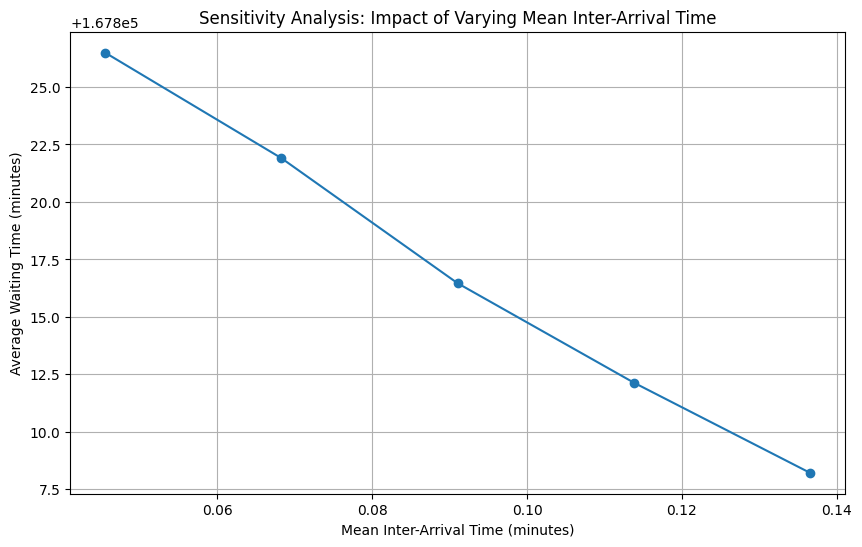

In [21]:
# Sensitivity Analysis based on Inter-Arrival and Service Times

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Load data from CSV
data = pd.read_csv('Merged_ServiceTime.csv')

# Convert 'StartTime' and 'PayTime' to datetime
data['StartTime'] = pd.to_datetime(data['StartTime'], format='%H:%M:%S')
data['PayTime'] = pd.to_datetime(data['PayTime'], format='%H:%M:%S')

# Calculate service times in minutes
data['ServiceTimeMinutes'] = data['ServTime']

# Calculate inter-arrival times in minutes
data['InterArrivalTime'] = data['StartTime'].diff().dt.total_seconds() / 60
data['InterArrivalTime'].iloc[0] = 0  # Assuming the first arrival is at time 0

# Function to simulate MM1 queue
def simulate_mm1_queue(inter_arrival_times, service_times):
    num_customers = len(inter_arrival_times)
    arrival_times = np.cumsum(inter_arrival_times)
    start_service_times = np.zeros(num_customers)
    end_service_times = np.zeros(num_customers)
    wait_times = np.zeros(num_customers)
    
    for i in range(num_customers):
        if i == 0:
            start_service_times[i] = arrival_times[i]
        else:
            start_service_times[i] = max(arrival_times[i], end_service_times[i-1])
        
        end_service_times[i] = start_service_times[i] + service_times[i]
        wait_times[i] = start_service_times[i] - arrival_times[i]

    return wait_times

# Sensitivity analysis by varying inter-arrival mean
mean_inter_arrival_times = np.linspace(data['InterArrivalTime'].mean() * 0.5, data['InterArrivalTime'].mean() * 1.5, 5)
mean_service_times = data['ServiceTimeMinutes'].mean()

results = []

for mean_ia in mean_inter_arrival_times:
    modified_inter_arrival_times = np.random.exponential(mean_ia, size=len(data['InterArrivalTime']))
    wait_times = simulate_mm1_queue(modified_inter_arrival_times, data['ServiceTimeMinutes'].values)
    results.append(np.mean(wait_times))

# Plotting the results
plt.figure(figsize=(10, 6))
plt.plot(mean_inter_arrival_times, results, marker='o')
plt.title('Sensitivity Analysis: Impact of Varying Mean Inter-Arrival Time')
plt.xlabel('Mean Inter-Arrival Time (minutes)')
plt.ylabel('Average Waiting Time (minutes)')
plt.grid(True)
plt.show()